# 칼만 필터를 이용한 객체 추적

이 노트북에서는 칼만 필터(Kalman Filter)의 기본 원리를 이해하고, LiDAR 기반 자율주행 시스템에서 
객체 추적에 칼만 필터를 적용하는 방법을 학습합니다.

## 학습 목표

- 칼만 필터의 수학적 기초 이해
- 선형 칼만 필터 구현 및 적용
- LiDAR 객체 추적에서의 칼만 필터 활용
- 확장 칼만 필터(EKF) 및 무향 칼만 필터(UKF) 소개
- 단일 객체 및 다중 객체 추적에 칼만 필터 적용

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import sys
import time
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter, ExtendedKalmanFilter, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.optimize import linear_sum_assignment

# 시각화 스타일 설정
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## 1. 칼만 필터의 이론적 배경

칼만 필터는 잡음이 있는 측정값으로부터 시스템의 상태를 추정하는 재귀적 알고리즘입니다.
이 알고리즘은 시스템의 이전 상태와 새로운 측정값을 모두 고려하여 현재 상태의 최적 추정치를 계산합니다.

### 칼만 필터의 주요 가정

1. 시스템이 선형적이다 (선형 상태 전이 모델 및 선형 측정 모델)
2. 프로세스 노이즈와 측정 노이즈가 가우시안 분포를 따른다
3. 노이즈는 서로 상관관계가 없다 (독립적)

### 칼만 필터의 주요 단계

1. **예측 단계 (Prediction)**
   - 이전 상태와 제어 입력을 기반으로 현재 상태 예측
   - 상태 공분산 행렬 업데이트

2. **업데이트 단계 (Update)**
   - 칼만 이득 계산
   - 측정값과 예측값의 차이를 반영하여 상태 추정치 업데이트
   - 상태 공분산 행렬 업데이트

### 간단한 1D 칼만 필터 구현

간단한 1차원 위치-속도 추적 문제를 통해 칼만 필터의 기본 원리를 이해해보겠습니다.

In [ ]:
def plot_filter_performance(time_steps, true_states, measurements, estimated_states, covariances):
    """
    칼만 필터의 추정 성능을 시각화
    
    Args:
        time_steps (numpy.ndarray): 시간 스텝
        true_states (numpy.ndarray): 실제 상태 [N, 2] (위치, 속도)
        measurements (numpy.ndarray): 측정 상태 [N, 1] (측정된 위치)
        estimated_states (numpy.ndarray): 추정 상태 [N, 2] (추정된 위치, 속도)
        covariances (numpy.ndarray): 공분산 행렬 [N, 2, 2]
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # 위치 그래프
    axes[0].plot(time_steps, true_states[:, 0], 'g-', label='실제 위치')
    axes[0].plot(time_steps, measurements, 'ro', markersize=4, alpha=0.7, label='측정된 위치')
    axes[0].plot(time_steps, estimated_states[:, 0], 'b-', label='추정된 위치')

    # 2시그마 불확실성 영역 추가
    pos_std = np.sqrt(covariances[:, 0, 0])
    axes[0].fill_between(time_steps, 
                         estimated_states[:, 0] - 2 * pos_std,
                         estimated_states[:, 0] + 2 * pos_std,
                         color='b', alpha=0.2, label='95% 신뢰 구간')
    
    axes[0].set_xlabel('시간 (초)')
    axes[0].set_ylabel('위치 (m)')
    axes[0].set_title('칼만 필터 위치 추정')
    axes[0].legend()
    axes[0].grid(True)
    
    # 속도 그래프
    axes[1].plot(time_steps, true_states[:, 1], 'g-', label='실제 속도')
    axes[1].plot(time_steps, estimated_states[:, 1], 'b-', label='추정된 속도')
    
    # 2시그마 불확실성 영역 추가
    vel_std = np.sqrt(covariances[:, 1, 1])
    axes[1].fill_between(time_steps, 
                         estimated_states[:, 1] - 2 * vel_std,
                         estimated_states[:, 1] + 2 * vel_std,
                         color='b', alpha=0.2, label='95% 신뢰 구간')
    
    axes[1].set_xlabel('시간 (초)')
    axes[1].set_ylabel('속도 (m/s)')
    axes[1].set_title('칼만 필터 속도 추정')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 1D 칼만 필터 시뮬레이션
def run_1d_kalman_filter():
    """
    1차원 위치-속도 모델에 대한 칼만 필터 시뮬레이션
    """
    # 시뮬레이션 설정
    dt = 0.1  # 시간 간격 (초)
    T = 10.0  # 총 시뮬레이션 시간 (초)
    time_steps = np.arange(0, T, dt)
    num_steps = len(time_steps)
    
    # 초기 상태 및 동작 모델 설정
    x0 = np.array([0.0, 1.0])  # 초기 위치와 속도
    
    # 프로세스 잡음과 측정 잡음 설정
    process_noise_std = 0.05  # 프로세스 잡음 표준편차
    measurement_noise_std = 0.5  # 측정 잡음 표준편차
    
    # 상태 전이 행렬 (F)
    F = np.array([
        [1.0, dt],
        [0.0, 1.0]
    ])
    
    # 제어 입력 행렬 (B)
    B = np.array([
        [0.5 * dt**2],
        [dt]
    ])
    
    # 측정 행렬 (H) - 위치만 측정
    H = np.array([[1.0, 0.0]])
    
    # 프로세스 잡음 공분산 행렬 (Q)
    q = process_noise_std**2
    Q = np.array([
        [dt**4/4, dt**3/2],
        [dt**3/2, dt**2]
    ]) * q
    
    # 측정 잡음 공분산 행렬 (R)
    R = np.array([[measurement_noise_std**2]])
    
    # 실제 상태, 측정값, 추정 상태를 저장할 배열 초기화
    true_states = np.zeros((num_steps, 2))
    measurements = np.zeros((num_steps, 1))
    estimated_states = np.zeros((num_steps, 2))
    covariances = np.zeros((num_steps, 2, 2))
    
    # 초기 상태 설정
    true_states[0] = x0
    
    # 초기 측정값 생성
    measurements[0] = H @ x0 + np.random.normal(0, measurement_noise_std)
    
    # 칼만 필터 초기화
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([measurements[0, 0], 0.0])  # 초기 상태 (위치는 측정값, 속도는 0으로 가정)
    kf.F = F
    kf.H = H
    kf.Q = Q
    kf.R = R
    kf.P = np.eye(2) * 1.0  # 초기 상태 공분산
    
    # 초기 추정값 저장
    estimated_states[0] = kf.x
    covariances[0] = kf.P
    
    # 시뮬레이션
    for i in range(1, num_steps):
        # 실제 상태 업데이트 (제어 입력 없이 등속 운동)
        u = 0.0  # 가속도 입력
        true_states[i] = F @ true_states[i-1] + B.flatten() * u + np.random.normal(0, process_noise_std, 2)
        
        # 측정값 생성
        measurements[i] = H @ true_states[i] + np.random.normal(0, measurement_noise_std)
        
        # 칼만 필터 적용
        kf.predict()
        kf.update(measurements[i])
        
        # 추정값 저장
        estimated_states[i] = kf.x
        covariances[i] = kf.P
    
    # 결과 시각화
    plot_filter_performance(time_steps, true_states, measurements, estimated_states, covariances)
    
    return true_states, measurements, estimated_states, covariances

# 1D 칼만 필터 실행
true_states, measurements, estimated_states, covariances = run_1d_kalman_filter()

## 2. 2D 객체 추적을 위한 칼만 필터

자율주행에서는 주로 2D(or 3D) 공간에서 객체의 위치와 속도를 추적합니다.
여기서는 2D 공간에서 객체 추적을 위한 칼만 필터를 구현해보겠습니다.

In [ ]:
def plot_2d_trajectory(true_states, measurements, estimated_states, covariances, time_steps):
    """
    2D 공간에서의 객체 궤적과 칼만 필터 추정 결과 시각화
    
    Args:
        true_states (numpy.ndarray): 실제 상태 [N, 4] (x, y, vx, vy)
        measurements (numpy.ndarray): 측정 상태 [N, 2] (x, y)
        estimated_states (numpy.ndarray): 추정 상태 [N, 4] (x, y, vx, vy)
        covariances (numpy.ndarray): 공분산 행렬 [N, 4, 4]
    """
    plt.figure(figsize=(10, 8))
    
    # 실제 궤적
    plt.plot(true_states[:, 0], true_states[:, 1], 'g-', linewidth=2, label='실제 궤적')
    
    # 측정값
    plt.scatter(measurements[:, 0], measurements[:, 1], c='r', s=15, alpha=0.7, label='측정값')
    
    # 추정 궤적
    plt.plot(estimated_states[:, 0], estimated_states[:, 1], 'b--', linewidth=2, label='추정 궤적')
    
    # 불확실성 타원 그리기 (몇 개 타임스텝에 대해서만)
    draw_steps = np.linspace(0, len(time_steps)-1, 10).astype(int)
    for i in draw_steps:
        # 공분산 행렬에서 위치 부분만 추출
        pos_cov = covariances[i, :2, :2]
        
        # 고유값과 고유벡터 계산
        eigenvalues, eigenvectors = np.linalg.eig(pos_cov)
        
        # 타원 각도 계산
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        
        # 95% 신뢰 구간을 위한 타원 반경 (2시그마)
        width, height = 2 * np.sqrt(5.991 * eigenvalues)
        
        # 타원 그리기
        ellipse = Ellipse(xy=(estimated_states[i, 0], estimated_states[i, 1]),
                          width=width, height=height, angle=angle,
                          edgecolor='b', fc='none', lw=1, alpha=0.5)
        plt.gca().add_patch(ellipse)
    
    # 시작점과 끝점 표시
    plt.plot(true_states[0, 0], true_states[0, 1], 'go', markersize=10, label='시작점')
    plt.plot(true_states[-1, 0], true_states[-1, 1], 'g*', markersize=10, label='끝점')
    
    plt.xlabel('X 위치 (m)')
    plt.ylabel('Y 위치 (m)')
    plt.title('2D 공간에서의 객체 추적 결과')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 시간에 따른 위치 오차 그래프
    plt.figure(figsize=(12, 5))
    
    # 위치 오차 계산
    position_errors = np.sqrt(np.sum((true_states[:, :2] - estimated_states[:, :2])**2, axis=1))
    
    plt.plot(time_steps, position_errors, 'b-', linewidth=2)
    plt.xlabel('시간 (초)')
    plt.ylabel('위치 오차 (m)')
    plt.title('칼만 필터 위치 추정 오차')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2D 칼만 필터 구현 및 시뮬레이션
def run_2d_kalman_filter(model_type='CV'):
    """
    2D 칼만 필터 시뮬레이션
    
    Args:
        model_type (str): 운동 모델 유형 ('CV': 등속 모델, 'CA': 등가속도 모델)
        
    Returns:
        tuple: (true_states, measurements, estimated_states, covariances, time_steps)
    """
    # 시뮬레이션 설정
    dt = 0.1  # 시간 간격 (초)
    T = 10.0  # 총 시뮬레이션 시간 (초)
    time_steps = np.arange(0, T, dt)
    num_steps = len(time_steps)
    
    # 프로세스 잡음과 측정 잡음 설정
    process_noise_std = 0.1  # 프로세스 잡음 표준편차
    measurement_noise_std = 0.5  # 측정 잡음 표준편차
    
    if model_type == 'CV':  # 등속 모델 (Constant Velocity)
        # 초기 상태: [x, y, vx, vy]
        x0 = np.array([0.0, 0.0, 2.0, 1.0])
        dim_x = 4
        
        # 상태 전이 행렬 (F)
        F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # 측정 행렬 (H) - 위치만 측정
        H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        
        # 프로세스 잡음 공분산 행렬 (Q)
        q = process_noise_std**2
        Q = np.array([
            [dt**4/4, 0, dt**3/2, 0],
            [0, dt**4/4, 0, dt**3/2],
            [dt**3/2, 0, dt**2, 0],
            [0, dt**3/2, 0, dt**2]
        ]) * q
        
    elif model_type == 'CA':  # 등가속도 모델 (Constant Acceleration)
        # 초기 상태: [x, y, vx, vy, ax, ay]
        x0 = np.array([0.0, 0.0, 2.0, 1.0, 0.1, 0.1])
        dim_x = 6
        
        # 상태 전이 행렬 (F)
        F = np.array([
            [1, 0, dt, 0, dt**2/2, 0],
            [0, 1, 0, dt, 0, dt**2/2],
            [0, 0, 1, 0, dt, 0],
            [0, 0, 0, 1, 0, dt],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
        
        # 측정 행렬 (H) - 위치만 측정
        H = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0]
        ])
        
        # 프로세스 잡음 공분산 행렬 (Q) - 가속도 변화에 대한 불확실성
        q = process_noise_std**2
        Q = np.zeros((6, 6))
        Q[4:, 4:] = np.array([[dt**2, 0], [0, dt**2]]) * q
        
    else:
        raise ValueError(f"지원하지 않는 모델 유형: {model_type}")
    
    # 측정 잡음 공분산 행렬 (R)
    R = np.eye(2) * measurement_noise_std**2
    
    # 실제 상태, 측정값, 추정 상태를 저장할 배열 초기화
    true_states = np.zeros((num_steps, dim_x))
    measurements = np.zeros((num_steps, 2))
    estimated_states = np.zeros((num_steps, dim_x))
    covariances = np.zeros((num_steps, dim_x, dim_x))
    
    # 초기 상태 설정
    true_states[0] = x0
    
    # 초기 측정값 생성
    measurements[0] = H @ x0 + np.random.normal(0, measurement_noise_std, 2)
    
    # 칼만 필터 초기화
    kf = KalmanFilter(dim_x=dim_x, dim_z=2)
    kf.x = np.zeros(dim_x)  # 초기 상태
    kf.x[:2] = measurements[0]  # 위치는 측정값으로 초기화
    if model_type == 'CV':
        kf.x[2:] = [1.0, 1.0]  # 초기 속도는 적당히 가정
    else:  # CA 모델
        kf.x[2:4] = [1.0, 1.0]  # 초기 속도
        kf.x[4:] = [0.0, 0.0]  # 초기 가속도
    
    kf.F = F
    kf.H = H
    kf.Q = Q
    kf.R = R
    kf.P = np.eye(dim_x) * 1.0  # 초기 상태 공분산
    
    # 초기 추정값 저장
    estimated_states[0] = kf.x
    covariances[0] = kf.P
    
    # 시뮬레이션 - 곡선 궤적 생성
    angle = 0
    for i in range(1, num_steps):
        # 실제 상태 업데이트 - 약간의 원형 궤적
        # 회전 각도 증가
        angle += 0.05
        
        if model_type == 'CV':
            # 속도 벡터 회전
            vx = 2.0 * np.cos(angle)
            vy = 2.0 * np.sin(angle)
            
            # 이전 위치에서 속도만큼 이동
            prev_x, prev_y = true_states[i-1, 0], true_states[i-1, 1]
            new_x = prev_x + vx * dt
            new_y = prev_y + vy * dt
            
            true_states[i] = [new_x, new_y, vx, vy]
            true_states[i] += np.random.normal(0, process_noise_std, 4)
            
        else:  # CA 모델
            # 속도와 가속도 벡터 회전
            vx = 2.0 * np.cos(angle)
            vy = 2.0 * np.sin(angle)
            ax = -2.0 * np.sin(angle) * 0.05  # 각속도 * 속도
            ay = 2.0 * np.cos(angle) * 0.05
            
            # 이전 위치에서 속도와 가속도만큼 이동
            prev_x, prev_y = true_states[i-1, 0], true_states[i-1, 1]
            prev_vx, prev_vy = true_states[i-1, 2], true_states[i-1, 3]
            
            new_x = prev_x + prev_vx * dt + 0.5 * ax * dt**2
            new_y = prev_y + prev_vy * dt + 0.5 * ay * dt**2
            new_vx = prev_vx + ax * dt
            new_vy = prev_vy + ay * dt
            
            true_states[i] = [new_x, new_y, new_vx, new_vy, ax, ay]
            true_states[i] += np.random.normal(0, process_noise_std, 6)
        
        # 측정값 생성
        measurements[i] = H @ true_states[i] + np.random.normal(0, measurement_noise_std, 2)
        
        # 칼만 필터 적용
        kf.predict()
        kf.update(measurements[i])
        
        # 추정값 저장
        estimated_states[i] = kf.x
        covariances[i] = kf.P
    
    return true_states, measurements, estimated_states, covariances, time_steps

# 2D 등속 모델 (CV) 칼만 필터 실행
true_states_cv, measurements_cv, estimated_states_cv, covariances_cv, time_steps_cv = run_2d_kalman_filter('CV')

# 결과 시각화
plot_2d_trajectory(true_states_cv, measurements_cv, estimated_states_cv, covariances_cv, time_steps_cv)

# 2D 등가속도 모델 (CA) 칼만 필터 실행
true_states_ca, measurements_ca, estimated_states_ca, covariances_ca, time_steps_ca = run_2d_kalman_filter('CA')

# 결과 시각화
plot_2d_trajectory(true_states_ca[:, :4], measurements_ca, estimated_states_ca[:, :4], covariances_ca[:, :4, :4], time_steps_ca)


## 3. LiDAR 객체 추적에서의 칼만 필터 활용

LiDAR 데이터를 사용한 객체 추적에서는 검출된 객체의 바운딩 박스 중심을 측정값으로 활용하여
칼만 필터를 적용합니다. 여기서는 간단한 시뮬레이션을 통해 자율주행 환경에서의 객체 추적을 구현해보겠습니다.


In [ ]:
def create_turning_trajectory(duration=10.0, dt=0.1, turn_rate=0.05, noise_std=0.02, initial_state=None):
    """
    회전하는 객체의 궤적 생성
    
    Args:
        duration (float): 시뮬레이션 시간 (초)
        dt (float): 시간 간격 (초)
        turn_rate (float): 회전 속도 (rad/s)
        noise_std (float): 위치 노이즈 표준편차
        initial_state (numpy.ndarray): 초기 상태 [x, y, vx, vy]
        
    Returns:
        tuple: (true_states, measurements, time_steps)
    """
    # 시간 스텝 설정
    time_steps = np.arange(0, duration, dt)
    num_steps = len(time_steps)
    
    # 초기 상태 설정
    if initial_state is None:
        initial_state = np.array([0.0, 0.0, 2.0, 0.0])  # 기본값: 원점에서 출발, x방향 속도 2 m/s
    
    # 측정 노이즈 설정
    measurement_noise_std = 0.2  # 측정 노이즈 표준편차
    
    # 상태와 측정값 저장할 배열 초기화
    true_states = np.zeros((num_steps, 4))  # [x, y, vx, vy]
    measurements = np.zeros((num_steps, 2))  # [x, y]
    
    # 초기 상태 설정
    true_states[0] = initial_state
    
    # 초기 측정값 생성
    measurements[0] = true_states[0, :2] + np.random.normal(0, measurement_noise_std, 2)
    
    # 회전 각도 초기화
    angle = np.arctan2(initial_state[3], initial_state[2])
    speed = np.sqrt(initial_state[2]**2 + initial_state[3]**2)
    
    # 시뮬레이션
    for i in range(1, num_steps):
        # 회전 각도 업데이트
        angle += turn_rate * dt
        
        # 속도 벡터 업데이트
        vx = speed * np.cos(angle)
        vy = speed * np.sin(angle)
        
        # 위치 업데이트
        prev_x, prev_y = true_states[i-1, 0], true_states[i-1, 1]
        new_x = prev_x + vx * dt
        new_y = prev_y + vy * dt
        
        # 프로세스 노이즈 추가
        process_noise = np.random.normal(0, noise_std, 4)
        true_states[i] = np.array([new_x, new_y, vx, vy]) + process_noise
        
        # 측정값 생성 (위치에 노이즈 추가)
        measurements[i] = true_states[i, :2] + np.random.normal(0, measurement_noise_std, 2)
    
    return true_states, measurements, time_steps

def simulate_lidar_detection(true_states, detection_probability=0.9, false_detection_rate=0.1, 
                           range_limit=50.0, position_noise_std=0.3):
    """
    LiDAR 객체 검출 시뮬레이션
    
    Args:
        true_states (numpy.ndarray): 실제 객체 상태 [N, 4] (x, y, vx, vy)
        detection_probability (float): 객체 검출 확률
        false_detection_rate (float): 허위 검출 비율
        range_limit (float): LiDAR 범위 제한 (m)
        position_noise_std (float): 위치 측정 노이즈 표준편차
        
    Returns:
        list: 프레임별 객체 검출 리스트 [프레임][검출_인덱스][x, y]
    """
    num_frames = len(true_states)
    detections = []
    
    for i in range(num_frames):
        frame_detections = []
        
        # 실제 객체 위치
        pos_x, pos_y = true_states[i, 0], true_states[i, 1]
        
        # 객체가 범위 내에 있고 검출 확률을 만족하는 경우
        distance = np.sqrt(pos_x**2 + pos_y**2)
        if distance < range_limit and np.random.rand() < detection_probability:
            # 위치에 노이즈 추가
            detected_x = pos_x + np.random.normal(0, position_noise_std)
            detected_y = pos_y + np.random.normal(0, position_noise_std)
            frame_detections.append([detected_x, detected_y])
        
        # 허위 검출 추가
        num_false_detections = int(np.random.poisson(false_detection_rate))
        for _ in range(num_false_detections):
            # 임의의 위치에 허위 검출 생성
            false_x = np.random.uniform(-range_limit, range_limit)
            false_y = np.random.uniform(-range_limit, range_limit)
            frame_detections.append([false_x, false_y])
        
        detections.append(frame_detections)
    
    return detections

class KalmanObjectTracker:
    """
    칼만 필터를 사용한 객체 추적기
    """
    def __init__(self, dt, process_noise_std, measurement_noise_std, initial_state=None):
        # 칼만 필터 초기화
        self.kf = KalmanFilter(dim_x=4, dim_z=2)
        
        # 초기 상태 설정
        if initial_state is not None:
            self.kf.x = initial_state
        else:
            self.kf.x = np.zeros(4)
        
        # 상태 전이 행렬 (F) - 등속 모델
        self.kf.F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # 측정 행렬 (H) - 위치만 측정
        self.kf.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        
        # 프로세스 잡음 공분산 행렬 (Q)
        q = process_noise_std**2
        self.kf.Q = np.array([
            [dt**4/4, 0, dt**3/2, 0],
            [0, dt**4/4, 0, dt**3/2],
            [dt**3/2, 0, dt**2, 0],
            [0, dt**3/2, 0, dt**2]
        ]) * q
        
        # 측정 잡음 공분산 행렬 (R)
        self.kf.R = np.eye(2) * measurement_noise_std**2
        
        # 상태 공분산 행렬 (P) 초기화
        self.kf.P = np.eye(4) * 1.0
        
        # 추적 이력
        self.history = [self.kf.x.copy()]
        self.covariance_history = [self.kf.P.copy()]
        
        # 추적 상태
        self.age = 0
        self.missed_detections = 0
        self.max_missed_detections = 5  # 최대 몇 프레임까지 검출 없이 추적을 유지할지
    
    def predict(self):
        """
        상태 예측
        """
        self.kf.predict()
        self.age += 1
        
        return self.kf.x
    
    def update(self, measurement):
        """
        측정값으로 상태 업데이트
        
        Args:
            measurement (numpy.ndarray): 측정값 [x, y]
        """
        self.kf.update(measurement)
        self.missed_detections = 0
        
        # 이력 추가
        self.history.append(self.kf.x.copy())
        self.covariance_history.append(self.kf.P.copy())
        
        return self.kf.x
    
    def missed_update(self):
        """
        측정값 없이 상태 유지 (예측만 수행)
        """
        self.missed_detections += 1
        
        # 이력 추가
        self.history.append(self.kf.x.copy())
        self.covariance_history.append(self.kf.P.copy())
        
        return self.kf.x, self.missed_detections > self.max_missed_detections
    
    def get_state(self):
        """
        현재 상태 반환
        """
        return self.kf.x
    
    def get_position(self):
        """
        현재 위치 반환
        """
        return self.kf.x[:2]
    
    def get_velocity(self):
        """
        현재 속도 반환
        """
        return self.kf.x[2:4]
    
    def get_covariance(self):
        """
        현재 공분산 행렬 반환
        """
        return self.kf.P
    
    def get_position_covariance(self):
        """
        위치 공분산 반환
        """
        return self.kf.P[:2, :2]

def associate_detections_to_trackers(detections, trackers, threshold=1.0):
    """
    검출과 추적기 간의 연관성 찾기
    
    Args:
        detections (list): 검출 리스트 [[x1, y1], [x2, y2], ...]
        trackers (list): 추적기 리스트 [tracker1, tracker2, ...]
        threshold (float): 최대 거리 임계값
        
    Returns:
        tuple: (matches, unmatched_detections, unmatched_trackers)
    """
    if len(trackers) == 0:
        return [], list(range(len(detections))), []
    
    if len(detections) == 0:
        return [], [], list(range(len(trackers)))
    
    # 거리 행렬 계산
    distance_matrix = np.zeros((len(detections), len(trackers)))
    
    for d, det in enumerate(detections):
        for t, trk in enumerate(trackers):
            trk_pos = trk.get_position()
            distance = np.linalg.norm(det - trk_pos)
            distance_matrix[d, t] = distance
    
    # 헝가리안 알고리즘으로 최적 할당 찾기
    from scipy.optimize import linear_sum_assignment
    rows, cols = linear_sum_assignment(distance_matrix)
    
    # 임계값보다 거리가 큰 경우 매칭에서 제외
    matches = []
    unmatched_detections = []
    unmatched_trackers = list(range(len(trackers)))
    
    for r, c in zip(rows, cols):
        if distance_matrix[r, c] <= threshold:
            matches.append((r, c))
            if c in unmatched_trackers:
                unmatched_trackers.remove(c)
        else:
            unmatched_detections.append(r)
    
    # 매칭되지 않은 검출 추가
    for d in range(len(detections)):
        if d not in rows:
            unmatched_detections.append(d)
    
    return matches, unmatched_detections, unmatched_trackers

def plot_tracking_results(true_states, detections, tracked_states, time_steps):
    """
    객체 추적 결과 시각화
    
    Args:
        true_states (numpy.ndarray): 실제 상태 [N, 4] (x, y, vx, vy)
        detections (list): 프레임별 검출 리스트 [프레임][검출_인덱스][x, y]
        tracked_states (list): 프레임별 추적 상태 리스트 [프레임][추적기_인덱스][상태]
        time_steps (numpy.ndarray): 시간 스텝
    """
    plt.figure(figsize=(12, 10))
    
    # 실제 궤적
    plt.plot(true_states[:, 0], true_states[:, 1], 'g-', linewidth=2, label='실제 궤적')
    
    # 검출 플롯
    for i, frame_dets in enumerate(detections):
        for det in frame_dets:
            plt.scatter(det[0], det[1], c='r', s=20, alpha=0.4)
    
    # 추적 결과 플롯
    tracked_x = []
    tracked_y = []
    
    for i, frame_tracks in enumerate(tracked_states):
        for track in frame_tracks:
            tracked_x.append(track[0])
            tracked_y.append(track[1])
            
            # 추정 상태의 불확실성 타원 그리기 (몇 개 프레임에 대해서만)
            if i % 10 == 0:
                pos_cov = track[-1][:2, :2]  # 위치 공분산
                
                # 고유값과 고유벡터 계산
                eigenvalues, eigenvectors = np.linalg.eig(pos_cov)
                
                # 타원 각도 계산
                angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
                
                # 95% 신뢰 구간을 위한 타원 반경 (2시그마)
                width, height = 2 * np.sqrt(5.991 * eigenvalues)
                
                # 타원 그리기
                ellipse = Ellipse(xy=(track[0], track[1]),
                                width=width, height=height, angle=angle,
                                edgecolor='b', fc='none', lw=1, alpha=0.5)
                plt.gca().add_patch(ellipse)
    
    plt.plot(tracked_x, tracked_y, 'b--', linewidth=2, label='추적 궤적')
    
    # 시작점과 끝점 표시
    plt.plot(true_states[0, 0], true_states[0, 1], 'go', markersize=10, label='시작점')
    plt.plot(true_states[-1, 0], true_states[-1, 1], 'g*', markersize=10, label='끝점')
    
    plt.xlabel('X 위치 (m)')
    plt.ylabel('Y 위치 (m)')
    plt.title('LiDAR 객체 추적 결과')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 시간에 따른 위치 오차 그래프
    plt.figure(figsize=(12, 5))
    
    # 위치 오차 계산
    position_errors = []
    for i, frame_tracks in enumerate(tracked_states):
        if frame_tracks:  # 추적기가 있는 경우
            # 첫 번째 추적기의 위치 사용
            track_pos = np.array([frame_tracks[0][0], frame_tracks[0][1]])
            true_pos = true_states[i, :2]
            error = np.linalg.norm(track_pos - true_pos)
            position_errors.append(error)
        else:
            position_errors.append(np.nan)  # 추적기가 없는 경우
    
    plt.plot(time_steps[:len(position_errors)], position_errors, 'b-', linewidth=2)
    plt.xlabel('시간 (초)')
    plt.ylabel('위치 오차 (m)')
    plt.title('칼만 필터 위치 추정 오차')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_multi_object_tracker(detections, dt, process_noise_std=0.1, measurement_noise_std=0.3):
    """
    다중 객체 추적 시뮬레이션
    
    Args:
        detections (list): 프레임별 검출 리스트 [프레임][검출_인덱스][x, y]
        dt (float): 시간 간격
        process_noise_std (float): 프로세스 노이즈 표준편차
        measurement_noise_std (float): 측정 노이즈 표준편차
        
    Returns:
        list: 프레임별 추적 상태 리스트 [프레임][추적기_인덱스][상태]
    """
    trackers = []  # 활성 추적기 리스트
    tracked_states = []  # 각 프레임의 추적 상태를 저장
    
    for frame_idx, frame_detections in enumerate(detections):
        # 현재 프레임의 추적 상태를 저장할 리스트
        current_tracked_states = []
        
        # 기존 추적기의 상태 예측
        for tracker in trackers:
            tracker.predict()
        
        # 검출과 추적기 연관성 찾기
        det_array = np.array(frame_detections) if len(frame_detections) > 0 else np.empty((0, 2))
        matches, unmatched_detections, unmatched_trackers = associate_detections_to_trackers(
            det_array, trackers)
        
        # 매칭된 검출로 추적기 업데이트
        for det_idx, trk_idx in matches:
            trackers[trk_idx].update(det_array[det_idx])
        
        # 매칭되지 않은 추적기 업데이트 (측정값 없이)
        trackers_to_remove = []
        for idx in unmatched_trackers:
            _, should_remove = trackers[idx].missed_update()
            if should_remove:
                trackers_to_remove.append(idx)
        
        # 제거할 추적기 제거 (역순으로)
        for idx in sorted(trackers_to_remove, reverse=True):
            trackers.pop(idx)
        
        # 새로운 검출로 추적기 생성
        for idx in unmatched_detections:
            # 초기 상태: [x, y, 0, 0] - 위치는 검출된 위치, 속도는 0으로 초기화
            initial_state = np.array([det_array[idx][0], det_array[idx][1], 0, 0])
            new_tracker = KalmanObjectTracker(dt, process_noise_std, measurement_noise_std, initial_state)
            trackers.append(new_tracker)
        
        # 현재 프레임의 모든 추적기 상태 저장
        for tracker in trackers:
            state = tracker.get_state()
            covariance = tracker.get_covariance()
            # 상태와 공분산 함께 저장
            current_tracked_states.append(np.concatenate([state, covariance.flatten()]))
        
        tracked_states.append(current_tracked_states)
    
    return tracked_states

# 객체 궤적 생성
duration = 10.0
dt = 0.1
true_states, measurements, time_steps = create_turning_trajectory(
    duration=duration, dt=dt, turn_rate=0.1, noise_std=0.05)

# LiDAR 검출 시뮬레이션
detections = simulate_lidar_detection(
    true_states, detection_probability=0.8, false_detection_rate=0.2)

# 객체 추적 실행
tracked_states = run_multi_object_tracker(
    detections, dt, process_noise_std=0.1, measurement_noise_std=0.3)

# 결과 시각화
plot_tracking_results(true_states, detections, tracked_states, time_steps)

## 4. 확장 칼만 필터(EKF)와 무향 칼만 필터(UKF)

실제 자율주행 시스템에서는 비선형 모델을 다루는 경우가 많습니다.
비선형 시스템에서는 확장 칼만 필터(EKF)나 무향 칼만 필터(UKF) 등을 활용합니다.

Kalman Filter Implementations for Autonomous Driving Applications

This module contains implementations of:
1. Extended Kalman Filter (EKF)
2. Unscented Kalman Filter (UKF)

These filters are commonly used for state estimation in autonomous driving,
particularly for tracking objects detected by LiDAR sensors.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

class ExtendedKalmanFilter:
    """
    Extended Kalman Filter implementation for nonlinear systems.
    
    The EKF extends the standard Kalman filter to nonlinear systems by linearizing
    the transition and observation models using Jacobian matrices.
    """
    
    def __init__(self, x_init, P_init, Q, R, dt=0.1):
        """
        Initialize the Extended Kalman Filter.
        
        Args:
            x_init (numpy.ndarray): Initial state vector [n x 1]
            P_init (numpy.ndarray): Initial state covariance matrix [n x n]
            Q (numpy.ndarray): Process noise covariance matrix [n x n]
            R (numpy.ndarray): Measurement noise covariance matrix [m x m]
            dt (float): Time step
        """
        self.x = x_init  # State vector
        self.P = P_init  # State covariance matrix
        self.Q = Q       # Process noise covariance
        self.R = R       # Measurement noise covariance
        self.dt = dt     # Time step
        
        self.n = x_init.shape[0]  # State dimension
        self.m = R.shape[0]       # Measurement dimension
        
        self.I = np.eye(self.n)   # Identity matrix
        
        # For tracking performance
        self.state_history = [self.x.copy()]
        self.cov_history = [self.P.copy()]
    
    def f(self, x, dt):
        """
        State transition function.
        Override this method for your specific system model.
        
        Args:
            x (numpy.ndarray): Current state [n x 1]
            dt (float): Time step
            
        Returns:
            numpy.ndarray: Predicted next state [n x 1]
        """
        # Example: Constant velocity model for object tracking
        # x = [px, py, pz, vx, vy, vz]
        F = np.eye(self.n)
        
        # Position updated based on velocity
        for i in range(3):  # For each position component
            F[i, i+3] = dt
        
        return F @ x
    
    def h(self, x):
        """
        Measurement function.
        Override this method for your specific measurement model.
        
        Args:
            x (numpy.ndarray): State vector [n x 1]
            
        Returns:
            numpy.ndarray: Predicted measurement [m x 1]
        """
        # Example: Direct observation of position only
        # z = [px, py, pz]
        H = np.zeros((3, self.n))
        H[0, 0] = 1  # Observe px
        H[1, 1] = 1  # Observe py
        H[2, 2] = 1  # Observe pz
        
        return H @ x
    
    def F_jacobian(self, x):
        """
        Jacobian of the state transition function.
        Override this method for your specific system model.
        
        Args:
            x (numpy.ndarray): Current state [n x 1]
            
        Returns:
            numpy.ndarray: Jacobian matrix [n x n]
        """
        # For constant velocity model
        F = np.eye(self.n)
        
        # Position updated based on velocity
        for i in range(3):  # For each position component
            F[i, i+3] = self.dt
        
        return F
    
    def H_jacobian(self, x):
        """
        Jacobian of the measurement function.
        Override this method for your specific measurement model.
        
        Args:
            x (numpy.ndarray): Current state [n x 1]
            
        Returns:
            numpy.ndarray: Jacobian matrix [m x n]
        """
        # For direct position measurement
        H = np.zeros((3, self.n))
        H[0, 0] = 1  # Observe px
        H[1, 1] = 1  # Observe py
        H[2, 2] = 1  # Observe pz
        
        return H
    
    def predict(self):
        """
        Predict step of the EKF.
        
        Returns:
            tuple: (predicted state, predicted covariance)
        """
        # Predict state
        self.x = self.f(self.x, self.dt)
        
        # Compute Jacobian of state transition function
        F = self.F_jacobian(self.x)
        
        # Predict covariance
        self.P = F @ self.P @ F.T + self.Q
        
        # Save history
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())
        
        return self.x, self.P
    
    def update(self, z):
        """
        Update step of the EKF using a measurement.
        
        Args:
            z (numpy.ndarray): Measurement vector [m x 1]
            
        Returns:
            tuple: (updated state, updated covariance)
        """
        # Compute Jacobian of measurement function
        H = self.H_jacobian(self.x)
        
        # Predicted measurement
        z_pred = self.h(self.x)
        
        # Innovation (measurement residual)
        y = z - z_pred
        
        # Innovation covariance
        S = H @ self.P @ H.T + self.R
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state
        self.x = self.x + K @ y
        
        # Update covariance with Joseph form for better numerical stability
        self.P = (self.I - K @ H) @ self.P @ (self.I - K @ H).T + K @ self.R @ K.T
        
        # Save history
        self.state_history[-1] = self.x.copy()
        self.cov_history[-1] = self.P.copy()
        
        return self.x, self.P
    
    def get_state(self):
        """
        Get current state.
        
        Returns:
            numpy.ndarray: Current state vector
        """
        return self.x
    
    def get_covariance(self):
        """
        Get current covariance.
        
        Returns:
            numpy.ndarray: Current covariance matrix
        """
        return self.P
    
    def get_history(self):
        """
        Get state and covariance history.
        
        Returns:
            tuple: (state_history, cov_history)
        """
        return np.array(self.state_history), np.array(self.cov_history)


class UnscentedKalmanFilter:
    """
    Unscented Kalman Filter implementation for nonlinear systems.
    
    The UKF uses the unscented transform to handle nonlinearities without requiring
    explicit Jacobian computations, often resulting in better performance for
    highly nonlinear systems.
    """
    
    def __init__(self, x_init, P_init, Q, R, dt=0.1, alpha=0.1, beta=2.0, kappa=0.0):
        """
        Initialize the Unscented Kalman Filter.
        
        Args:
            x_init (numpy.ndarray): Initial state vector [n x 1]
            P_init (numpy.ndarray): Initial state covariance matrix [n x n]
            Q (numpy.ndarray): Process noise covariance matrix [n x n]
            R (numpy.ndarray): Measurement noise covariance matrix [m x m]
            dt (float): Time step
            alpha (float): Spread of sigma points (usually small, e.g., 1e-3)
            beta (float): Prior knowledge parameter (2 is optimal for Gaussian)
            kappa (float): Secondary scaling parameter (usually 0 or 3-n)
        """
        self.x = x_init  # State vector
        self.P = P_init  # State covariance matrix
        self.Q = Q       # Process noise covariance
        self.R = R       # Measurement noise covariance
        self.dt = dt     # Time step
        
        self.n = x_init.shape[0]  # State dimension
        self.m = R.shape[0]       # Measurement dimension
        
        # UKF parameters
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        
        # Calculate derived UKF parameters
        self.lam = self.alpha**2 * (self.n + self.kappa) - self.n
        
        # Calculate weights
        self._calculate_weights()
        
        # For tracking performance
        self.state_history = [self.x.copy()]
        self.cov_history = [self.P.copy()]
    
    def _calculate_weights(self):
        """
        Calculate the weights for mean and covariance for sigma points.
        """
        # Number of sigma points
        n_sigma = 2 * self.n + 1
        
        # Initialize weights
        self.Wm = np.zeros(n_sigma)  # Weights for mean
        self.Wc = np.zeros(n_sigma)  # Weights for covariance
        
        # Calculate weights
        den = self.n + self.lam
        self.Wm[0] = self.lam / den
        self.Wc[0] = self.Wm[0] + (1 - self.alpha**2 + self.beta)
        
        # Remaining weights are equal
        for i in range(1, n_sigma):
            self.Wm[i] = 1.0 / (2.0 * den)
            self.Wc[i] = self.Wm[i]
    
    def f(self, x, dt):
        """
        State transition function.
        Override this method for your specific system model.
        
        Args:
            x (numpy.ndarray): Current state [n x 1]
            dt (float): Time step
            
        Returns:
            numpy.ndarray: Predicted next state [n x 1]
        """
        # Example: Constant velocity model for object tracking
        # x = [px, py, pz, vx, vy, vz]
        F = np.eye(self.n)
        
        # Position updated based on velocity
        for i in range(3):  # For each position component
            F[i, i+3] = dt
        
        return F @ x
    
    def h(self, x):
        """
        Measurement function.
        Override this method for your specific measurement model.
        
        Args:
            x (numpy.ndarray): State vector [n x 1]
            
        Returns:
            numpy.ndarray: Predicted measurement [m x 1]
        """
        # Example: Direct observation of position only
        # z = [px, py, pz]
        H = np.zeros((3, self.n))
        H[0, 0] = 1  # Observe px
        H[1, 1] = 1  # Observe py
        H[2, 2] = 1  # Observe pz
        
        return H @ x
    
    def generate_sigma_points(self, x, P):
        """
        Generate sigma points around the state mean.
        
        Args:
            x (numpy.ndarray): Mean state vector [n x 1]
            P (numpy.ndarray): State covariance matrix [n x n]
            
        Returns:
            numpy.ndarray: Sigma points [n x (2n+1)]
        """
        n = len(x)
        sigma_pts = np.zeros((n, 2*n+1))
        
        # Calculate square root of (n+lambda)*P using Cholesky decomposition
        scaled_P = (n + self.lam) * P
        try:
            sqrt_P = sqrtm(scaled_P)
        except:
            # If sqrtm fails, try Cholesky
            try:
                sqrt_P = np.linalg.cholesky(scaled_P)
            except:
                # If still fails, add small diagonal term and try again
                scaled_P += 1e-8 * np.eye(n)
                sqrt_P = sqrtm(scaled_P)
        
        # Set first sigma point at mean
        sigma_pts[:, 0] = x.flatten()
        
        # Set remaining sigma points
        for i in range(n):
            sigma_pts[:, i+1] = x.flatten() + sqrt_P[:, i]
            sigma_pts[:, i+1+n] = x.flatten() - sqrt_P[:, i]
        
        return sigma_pts
    
    def predict(self):
        """
        Predict step of the UKF.
        
        Returns:
            tuple: (predicted state, predicted covariance)
        """
        # Generate sigma points
        sigma_pts = self.generate_sigma_points(self.x, self.P)
        n_sigma = sigma_pts.shape[1]
        
        # Propagate sigma points through process model
        sigma_pts_pred = np.zeros_like(sigma_pts)
        for i in range(n_sigma):
            # Create state vector from sigma point
            x_sigma = sigma_pts[:, i].reshape(-1, 1)
            # Propagate through process model
            x_sigma_pred = self.f(x_sigma, self.dt)
            # Store predicted sigma point
            sigma_pts_pred[:, i] = x_sigma_pred.flatten()
        
        # Calculate predicted mean
        self.x = np.zeros((self.n, 1))
        for i in range(n_sigma):
            self.x += self.Wm[i] * sigma_pts_pred[:, i].reshape(-1, 1)
        
        # Calculate predicted covariance
        self.P = np.zeros((self.n, self.n))
        for i in range(n_sigma):
            diff = sigma_pts_pred[:, i].reshape(-1, 1) - self.x
            self.P += self.Wc[i] * diff @ diff.T
        
        # Add process noise
        self.P += self.Q
        
        # Save history
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())
        
        return self.x, self.P, sigma_pts_pred
    
    def update(self, z):
        """
        Update step of the UKF using a measurement.
        
        Args:
            z (numpy.ndarray): Measurement vector [m x 1]
            
        Returns:
            tuple: (updated state, updated covariance)
        """
        # Get predicted sigma points from predict step
        _, _, sigma_pts_pred = self.predict()
        n_sigma = sigma_pts_pred.shape[1]
        
        # Propagate sigma points through measurement model
        z_sigma = np.zeros((self.m, n_sigma))
        for i in range(n_sigma):
            x_sigma = sigma_pts_pred[:, i].reshape(-1, 1)
            z_sigma[:, i] = self.h(x_sigma).flatten()
        
        # Calculate predicted measurement
        z_pred = np.zeros((self.m, 1))
        for i in range(n_sigma):
            z_pred += self.Wm[i] * z_sigma[:, i].reshape(-1, 1)
        
        # Calculate innovation covariance
        S = np.zeros((self.m, self.m))
        for i in range(n_sigma):
            diff = z_sigma[:, i].reshape(-1, 1) - z_pred
            S += self.Wc[i] * diff @ diff.T
        
        # Add measurement noise
        S += self.R
        
        # Calculate cross correlation matrix
        Pxz = np.zeros((self.n, self.m))
        for i in range(n_sigma):
            diff_x = sigma_pts_pred[:, i].reshape(-1, 1) - self.x
            diff_z = z_sigma[:, i].reshape(-1, 1) - z_pred
            Pxz += self.Wc[i] * diff_x @ diff_z.T
        
        # Calculate Kalman gain
        K = Pxz @ np.linalg.inv(S)
        
        # Update state
        self.x = self.x + K @ (z - z_pred)
        
        # Update covariance
        self.P = self.P - K @ S @ K.T
        
        # Save history
        self.state_history[-1] = self.x.copy()
        self.cov_history[-1] = self.P.copy()
        
        return self.x, self.P
    
    def get_state(self):
        """
        Get current state.
        
        Returns:
            numpy.ndarray: Current state vector
        """
        return self.x
    
    def get_covariance(self):
        """
        Get current covariance.
        
        Returns:
            numpy.ndarray: Current covariance matrix
        """
        return self.P
    
    def get_history(self):
        """
        Get state and covariance history.
        
        Returns:
            tuple: (state_history, cov_history)
        """
        return np.array(self.state_history), np.array(self.cov_history)

# Example usage for object tracking

In [7]:
def example_object_tracking():
    """
    Example of using both EKF and UKF for object tracking.
    """
    # Simulation parameters
    dt = 0.1  # Time step (s)
    t_end = 10  # End time (s)
    num_steps = int(t_end / dt)
    
    # Initial state [px, py, pz, vx, vy, vz]
    x_true_init = np.array([[0], [0], [0], [1], [2], [0.5]])
    
    # Process noise (affects acceleration)
    sigma_a = 0.1  # Standard deviation of acceleration noise
    
    # Measurement noise
    sigma_m = 0.5  # Standard deviation of measurement noise
    
    # Initialize true state
    x_true = x_true_init.copy()
    
    # Initialize arrays to store data
    t_values = np.linspace(0, t_end, num_steps+1)
    x_true_history = [x_true_init.copy()]
    z_history = []
    
    # State transition matrix for ground truth (constant velocity)
    F = np.eye(6)
    for i in range(3):  # For each position component
        F[i, i+3] = dt
    
    # Generate ground truth and measurements
    for t_idx in range(1, num_steps+1):
        # True state evolves according to constant velocity model plus noise
        process_noise = np.random.normal(0, sigma_a, (3, 1))
        
        # Add process noise to acceleration, affecting velocity
        accel_effect = np.vstack([
            0.5 * dt**2 * process_noise,
            dt * process_noise
        ])
        
        # Propagate true state
        x_true = F @ x_true + accel_effect
        x_true_history.append(x_true.copy())
        
        # Generate noisy measurement of position
        z = x_true[:3] + np.random.normal(0, sigma_m, (3, 1))
        z_history.append(z.copy())
    
    # Convert to arrays
    x_true_history = np.array(x_true_history).squeeze()
    z_history = np.array(z_history).squeeze()
    
    # Initialize EKF
    # State vector: [px, py, pz, vx, vy, vz]
    x_init_ekf = x_true_init + np.random.normal(0, 0.5, (6, 1))
    
    # Initial covariance (high uncertainty about initial velocity)
    P_init_ekf = np.diag([1.0, 1.0, 1.0, 5.0, 5.0, 5.0])
    
    # Process noise covariance
    Q_ekf = np.zeros((6, 6))
    # Affect velocity directly
    q_vel = (sigma_a * dt)**2
    Q_ekf[3:, 3:] = np.eye(3) * q_vel
    
    # Measurement noise covariance
    R_ekf = np.eye(3) * sigma_m**2
    
    # Create and initialize EKF
    ekf = ExtendedKalmanFilter(x_init_ekf, P_init_ekf, Q_ekf, R_ekf, dt)
    
    # Initialize UKF
    # Using same initial conditions as EKF for fair comparison
    x_init_ukf = x_init_ekf.copy()
    P_init_ukf = P_init_ekf.copy()
    Q_ukf = Q_ekf.copy()
    R_ukf = R_ekf.copy()
    
    # Create and initialize UKF
    ukf = UnscentedKalmanFilter(x_init_ukf, P_init_ukf, Q_ukf, R_ukf, dt)
    
    # Run filters
    for t_idx in range(1, num_steps):
        # Get measurement
        z = z_history[t_idx-1].reshape(-1, 1)
        
        # EKF predict and update
        ekf.predict()
        ekf.update(z)
        
        # UKF update (predict is called within update)
        ukf.update(z)
    
    # Get filter histories
    ekf_state_history, ekf_cov_history = ekf.get_history()
    ukf_state_history, ukf_cov_history = ukf.get_history()
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Position components
    component_names = ['X Position', 'Y Position', 'Z Position', 'X Velocity', 'Y Velocity', 'Z Velocity']
    
    for i in range(6):
        plt.subplot(3, 2, i+1)
        plt.plot(t_values, x_true_history[:, i], 'k-', label='True')
        plt.plot(t_values, ekf_state_history[:, i], 'b--', label='EKF')
        plt.plot(t_values, ukf_state_history[:, i], 'r-.', label='UKF')
        
        if i < 3:  # Plot measurements for position
            plt.scatter(t_values[1:], z_history[:, i], marker='.', color='g', alpha=0.5, label='Measurement')
        
        plt.title(component_names[i])
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3D trajectory
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(x_true_history[:, 0], x_true_history[:, 1], x_true_history[:, 2], 'k-', label='True')
    ax.plot(ekf_state_history[:, 0], ekf_state_history[:, 1], ekf_state_history[:, 2], 'b--', label='EKF')
    ax.plot(ukf_state_history[:, 0], ukf_state_history[:, 1], ukf_state_history[:, 2], 'r-.', label='UKF')
    ax.scatter(z_history[:, 0], z_history[:, 1], z_history[:, 2], marker='.', color='g', alpha=0.5, label='Measurements')
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title('3D Trajectory')
    ax.legend()
    
    plt.show()


class NonlinearEKF(ExtendedKalmanFilter):
    """
    Extended Kalman Filter for a more complex nonlinear system.
    This example demonstrates a system with nonlinear dynamics.
    """
    
    def f(self, x, dt):
        """
        Nonlinear state transition function.
        In this example, we model a target with constant turn rate.
        
        Args:
            x (numpy.ndarray): Current state [n x 1]
                x = [px, py, v, heading, turn_rate]
                where px, py are position, v is speed, heading is direction, turn_rate is angular velocity
            dt (float): Time step
            
        Returns:
            numpy.ndarray: Predicted next state [n x 1]
        """
        # Extract state components
        px = x[0, 0]
        py = x[1, 0]
        v = x[2, 0]
        theta = x[3, 0]
        omega = x[4, 0]  # Turn rate
        
        # Handle special case to avoid division by zero
        if abs(omega) < 1e-6:
            # Straight line motion
            px_new = px + v * dt * np.cos(theta)
            py_new = py + v * dt * np.sin(theta)
            theta_new = theta
        else:
            # Turning motion
            px_new = px + (v/omega) * (np.sin(theta + omega*dt) - np.sin(theta))
            py_new = py + (v/omega) * (np.cos(theta) - np.cos(theta + omega*dt))
            theta_new = theta + omega * dt
        
        # New state
        x_new = np.array([
            [px_new],
            [py_new],
            [v],
            [theta_new],
            [omega]
        ])
        
        return x_new
    
    def h(self, x):
        """
        Measurement function that returns position and heading.
        
        Args:
            x (numpy.ndarray): State vector [n x 1]
            
        Returns:
            numpy.ndarray: Predicted measurement [m x 1]
        """
        # Measure position and heading (px, py, theta)
        H = np.zeros((3, self.n))
        H[0, 0] = 1  # px
        H[1, 1] = 1  # py
        H[2, 3] = 1  # theta
        
        return H @ x


def demonstrate_nonlinear_tracking():
    """
    Demonstrate and compare the EKF and UKF for a nonlinear system.
    """
    # Simulation parameters
    dt = 0.1  # Time step (s)
    t_end = 30  # End time (s)
    num_steps = int(t_end / dt)
    
    # Initial state [px, py, v, heading, turn_rate]
    x_true_init = np.array([[0], [0], [5], [np.pi/4], [0.1]])
    
    # Process noise
    sigma_v = 0.1  # Velocity noise
    sigma_omega = 0.01  # Turn rate noise
    
    # Measurement noise
    sigma_pos = 0.3  # Position noise
    sigma_theta = 0.05  # Heading noise
    
    # Initialize true state
    x_true = x_true_init.copy()
    
    # Initialize arrays to store data
    t_values = np.linspace(0, t_end, num_steps+1)
    x_true_history = [x_true_init.copy()]
    z_history = []
    
    # Generate ground truth and measurements
    for t_idx in range(1, num_steps+1):
        # Extract state
        px, py, v, theta, omega = x_true.flatten()
        
        # Add noise to velocity and turn rate
        v += np.random.normal(0, sigma_v)
        omega += np.random.normal(0, sigma_omega)
        
        # Update position and heading based on velocity and turn rate
        if abs(omega) < 1e-6:
            px += v * dt * np.cos(theta)
            py += v * dt * np.sin(theta)
        else:
            px += (v/omega) * (np.sin(theta + omega*dt) - np.sin(theta))
            py += (v/omega) * (np.cos(theta) - np.cos(theta + omega*dt))
        
        theta += omega * dt
        
        # Create updated state
        x_true = np.array([[px], [py], [v], [theta], [omega]])
        x_true_history.append(x_true.copy())
        
        # Generate noisy measurement of position and heading
        z_px = px + np.random.normal(0, sigma_pos)
        z_py = py + np.random.normal(0, sigma_pos)
        z_theta = theta + np.random.normal(0, sigma_theta)
        
        z = np.array([[z_px], [z_py], [z_theta]])
        z_history.append(z.copy())
    
    # Convert to arrays
    x_true_history = np.array(x_true_history).squeeze()
    z_history = np.array(z_history).squeeze()
    
    # Initialize NonlinearEKF
    x_init_ekf = x_true_init + np.array([[0.5], [0.5], [0.2], [0.1], [0.02]])
    P_init_ekf = np.diag([1.0, 1.0, 1.0, 0.5, 0.1])
    
    # Process noise covariance
    Q_ekf = np.diag([0.0, 0.0, sigma_v**2, 0.0, sigma_omega**2])
    
    # Measurement noise covariance
    R_ekf = np.diag([sigma_pos**2, sigma_pos**2, sigma_theta**2])
    
    # Create and initialize NonlinearEKF
    ekf = NonlinearEKF(x_init_ekf, P_init_ekf, Q_ekf, R_ekf, dt)
    
    # Initialize NonlinearUKF with same parameters
    ukf = NonlinearUKF(x_init_ekf, P_init_ekf, Q_ekf, R_ekf, dt, alpha=0.1, beta=2.0, kappa=0.0)
    
    # Run filters
    for t_idx in range(1, num_steps):
        # Get measurement
        z = z_history[t_idx-1].reshape(-1, 1)
        
        # EKF predict and update
        ekf.predict()
        ekf.update(z)
        
        # UKF update (predict is called within update)
        ukf.update(z)
    
    # Get filter histories
    ekf_state_history, ekf_cov_history = ekf.get_history()
    ukf_state_history, ukf_cov_history = ukf.get_history()
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Component names
    component_names = ['X Position', 'Y Position', 'Velocity', 'Heading', 'Turn Rate']
    
    for i in range(5):
        plt.subplot(3, 2, i+1)
        plt.plot(t_values, x_true_history[:, i], 'k-', label='True')
        plt.plot(t_values, ekf_state_history[:, i], 'b--', label='EKF')
        plt.plot(t_values, ukf_state_history[:, i], 'r-.', label='UKF')
        
        if i < 2:  # Plot position measurements
            plt.scatter(t_values[1:], z_history[:, i], marker='.', color='g', alpha=0.5, label='Measurement')
        elif i == 3:  # Plot heading measurements
            plt.scatter(t_values[1:], z_history[:, 2], marker='.', color='g', alpha=0.5, label='Measurement')
        
        plt.title(component_names[i])
        plt.grid(True)
        plt.legend()
    
    # Plot 2D trajectory
    plt.subplot(3, 2, 6)
    plt.plot(x_true_history[:, 0], x_true_history[:, 1], 'k-', label='True')
    plt.plot(ekf_state_history[:, 0], ekf_state_history[:, 1], 'b--', label='EKF')
    plt.plot(ukf_state_history[:, 0], ukf_state_history[:, 1], 'r-.', label='UKF')
    plt.scatter(z_history[:, 0], z_history[:, 1], marker='.', color='g', alpha=0.3, label='Measurements')
    
    plt.title('2D Trajectory')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

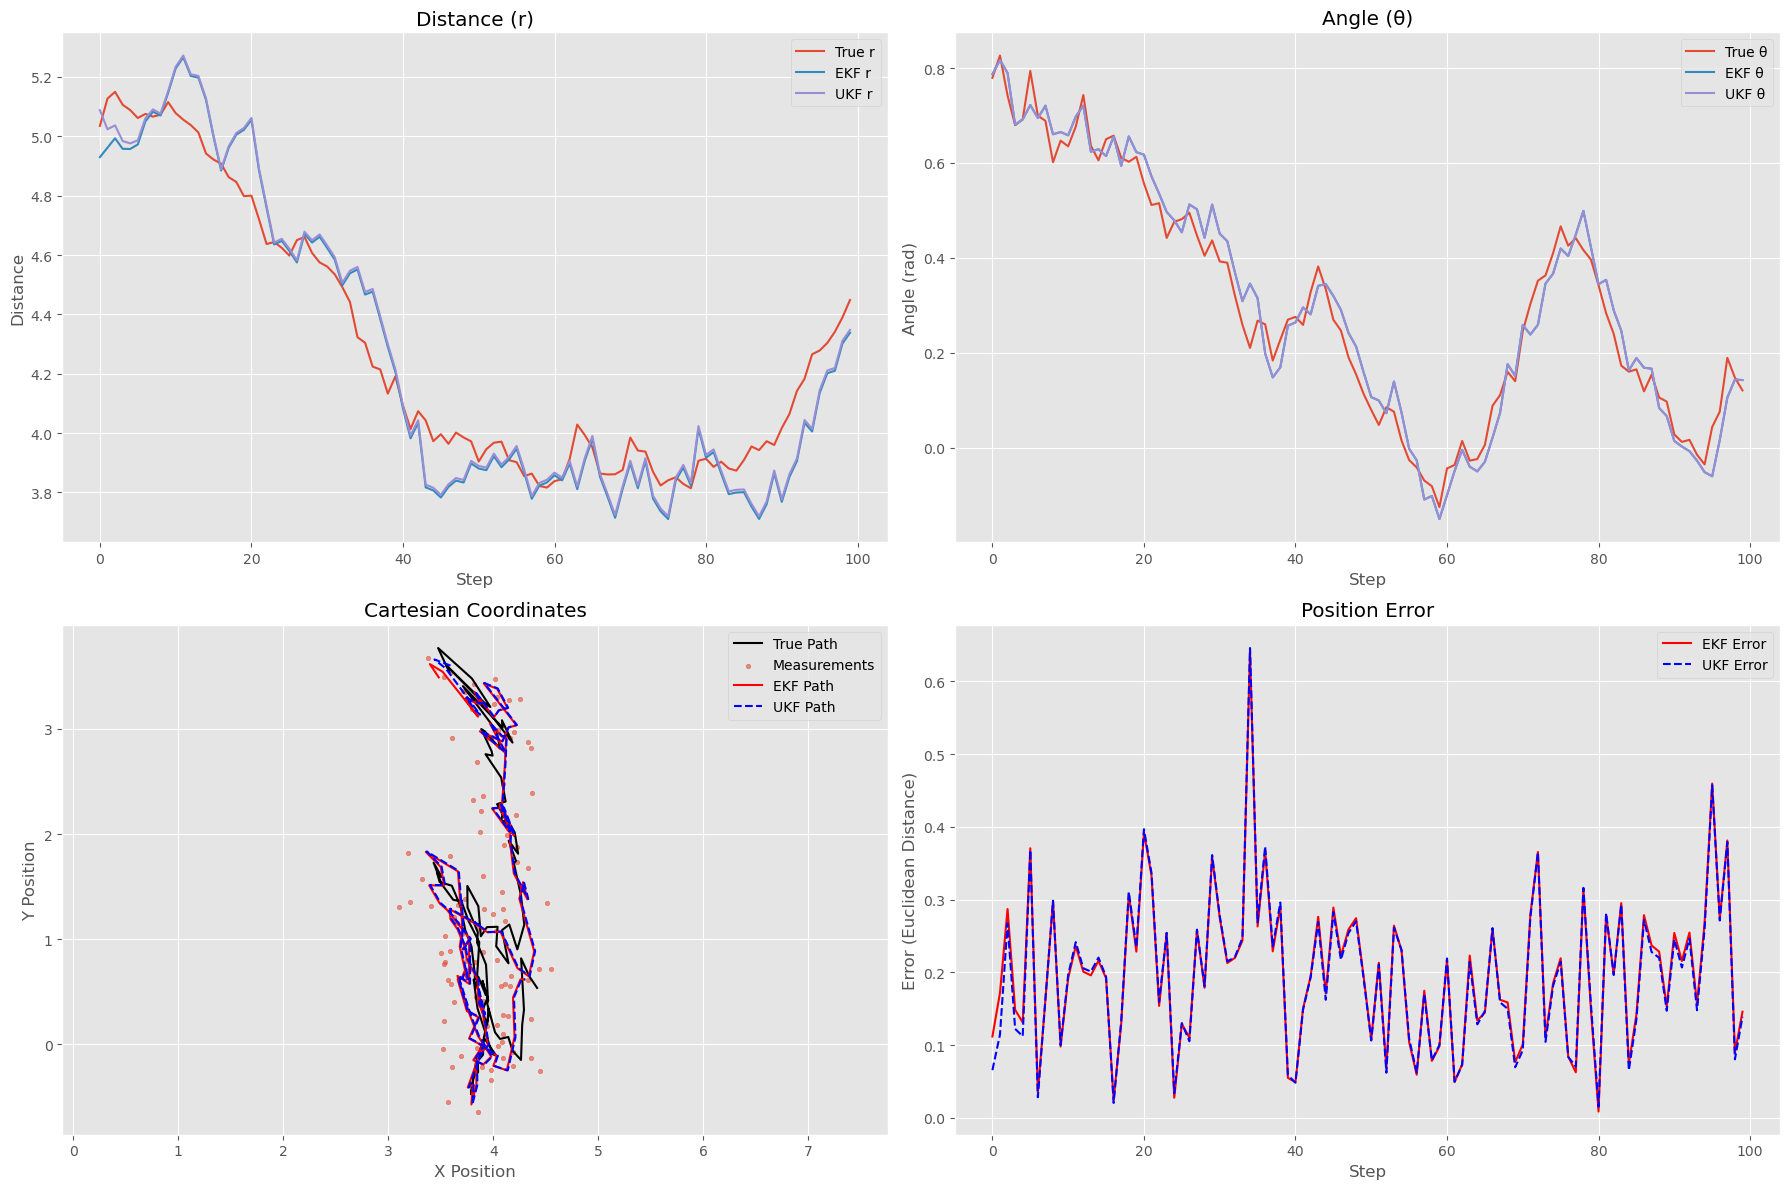

평균 EKF 오차: 0.1998
평균 UKF 오차: 0.1971
개선율: 1.37%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
import math

# 비선형 시스템 모델 정의 - 좌표계 변환 예제
# 극좌표계 -> 직교좌표계 변환이라는 비선형 문제를 통해 EKF와 UKF의 성능 비교
class NonlinearSystem:
    def __init__(self, process_noise=0.1, measurement_noise=0.5):
        self.process_noise = process_noise  # 프로세스 노이즈
        self.measurement_noise = measurement_noise  # 측정 노이즈
        self.dt = 0.1  # 시간 간격
        
        # 초기 상태
        # 상태: [r, theta, v_r, v_theta]
        # r = 거리, theta = 각도, v_r = 거리 변화율, v_theta = 각도 변화율
        self.x = np.array([5.0, np.pi/4, 0.1, 0.01])  
        
    def f(self, x, dt):
        """상태 전이 함수: 극좌표계에서의 상태 업데이트"""
        # x = [r, theta, v_r, v_theta]
        r, theta, v_r, v_theta = x
        
        # 거리와 각도 업데이트
        r_new = r + v_r * dt
        theta_new = theta + v_theta * dt
        
        # 속도는 약간의 감쇠가 있다고 가정
        v_r_new = v_r * 0.99
        v_theta_new = v_theta * 0.99
        
        return np.array([r_new, theta_new, v_r_new, v_theta_new])
    
    def h(self, x):
        """측정 함수: 극좌표계 -> 직교좌표계 변환"""
        # x = [r, theta, v_r, v_theta]
        r, theta, _, _ = x
        
        # 직교좌표계로 변환
        px = r * np.cos(theta)
        py = r * np.sin(theta)
        
        return np.array([px, py])
    
    def get_f_jacobian(self, x, dt):
        """상태 전이 함수의 자코비안"""
        # x = [r, theta, v_r, v_theta]
        F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 0.99, 0],
            [0, 0, 0, 0.99]
        ])
        return F
    
    def get_h_jacobian(self, x):
        """측정 함수의 자코비안"""
        # x = [r, theta, v_r, v_theta]
        r, theta, _, _ = x
        
        H = np.array([
            [np.cos(theta), -r * np.sin(theta), 0, 0],
            [np.sin(theta), r * np.cos(theta), 0, 0]
        ])
        return H
    
    def step(self):
        """시스템의 한 스텝을 진행"""
        # 상태 업데이트
        self.x = self.f(self.x, self.dt)
        
        # 프로세스 노이즈 적용
        self.x += np.random.normal(0, self.process_noise, size=4)
        
        # 측정값 생성
        z = self.h(self.x)
        
        # 측정 노이즈 적용
        z += np.random.normal(0, self.measurement_noise, size=2)
        
        return z
    
    def get_true_state(self):
        """현재 실제 상태 반환"""
        return self.x
    
    def get_true_cartesian(self):
        """실제 상태를 직교좌표계로 변환"""
        r, theta, _, _ = self.x
        px = r * np.cos(theta)
        py = r * np.sin(theta)
        return np.array([px, py])

    
class ExtendedKF:
    def __init__(self, system):
        self.system = system
        
        # 4차원 상태 벡터 [r, theta, v_r, v_theta]
        self.ekf = ExtendedKalmanFilter(dim_x=4, dim_z=2)
        
        # 초기 상태 [r, theta, v_r, v_theta]
        self.ekf.x = np.array([4.5, np.pi/4 - 0.1, 0, 0])  # 약간의 오차로 시작
        
        # 상태 공분산 행렬
        self.ekf.P = np.diag([1.0, 0.1, 0.1, 0.01])
        
        # 측정 노이즈 공분산
        self.ekf.R = np.eye(2) * (system.measurement_noise ** 2)
        
        # 프로세스 노이즈 공분산
        self.ekf.Q = np.eye(4) * (system.process_noise ** 2)
        
    def predict(self):
        """EKF 예측 단계"""
        dt = self.system.dt
        
        # 상태 전이 함수 설정
        self.ekf.F = self.system.get_f_jacobian(self.ekf.x, dt)
        
        # 비선형 상태 전이 함수 설정
        def f_ekf(x, dt=dt):
            return self.system.f(x, dt)
        
        self.ekf.f = f_ekf
        
        # 예측
        self.ekf.predict()
        
    def update(self, z):
        """EKF 업데이트 단계"""
        # 측정 자코비안 함수 정의
        def HJacobian(x):
            return self.system.get_h_jacobian(x)
        
        # 비선형 측정 함수 정의
        def Hx(x):
            return self.system.h(x)
        
        # 업데이트 - FilterPy 구현에서는 필수 인자로 HJacobian과 Hx를 전달해야 함
        self.ekf.update(z, HJacobian, Hx)
        
    def get_state(self):
        """현재 추정 상태 반환"""
        return self.ekf.x
    
    def get_cartesian(self):
        """추정 상태를 직교좌표계로 변환"""
        r, theta, _, _ = self.ekf.x
        px = r * np.cos(theta)
        py = r * np.sin(theta)
        return np.array([px, py])
    
    def get_covariance(self):
        """상태 공분산 행렬 반환"""
        return self.ekf.P
    
    def get_cartesian_covariance(self):
        """상태 공분산 행렬을 직교좌표계로 변환"""
        # 자코비안 계산
        H = self.system.get_h_jacobian(self.ekf.x)
        
        # 직교좌표계에서의 공분산
        return H @ self.ekf.P @ H.T


class UnscentedKF:
    def __init__(self, system):
        self.system = system
        
        # 시그마 포인트 파라미터 설정
        sigma_points = MerweScaledSigmaPoints(4, alpha=0.1, beta=2., kappa=0.)
        
        # UKF 초기화
        self.ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=system.dt, fx=self.fx, hx=self.hx, points=sigma_points)
        
        # 초기 상태 [r, theta, v_r, v_theta]
        self.ukf.x = np.array([4.5, np.pi/4 - 0.1, 0, 0])  # 약간의 오차로 시작
        
        # 상태 공분산 행렬
        self.ukf.P = np.diag([1.0, 0.1, 0.1, 0.01])
        
        # 측정 노이즈 공분산
        self.ukf.R = np.eye(2) * (system.measurement_noise ** 2)
        
        # 프로세스 노이즈 공분산
        self.ukf.Q = np.eye(4) * (system.process_noise ** 2)
        
    def fx(self, x, dt):
        """UKF용 상태 전이 함수"""
        return self.system.f(x, dt)
    
    def hx(self, x):
        """UKF용 측정 함수"""
        return self.system.h(x)
    
    def predict(self):
        """UKF 예측 단계"""
        self.ukf.predict()
        
    def update(self, z):
        """UKF 업데이트 단계"""
        self.ukf.update(z)
        
    def get_state(self):
        """현재 추정 상태 반환"""
        return self.ukf.x
    
    def get_cartesian(self):
        """추정 상태를 직교좌표계로 변환"""
        r, theta, _, _ = self.ukf.x
        px = r * np.cos(theta)
        py = r * np.sin(theta)
        return np.array([px, py])
    
    def get_covariance(self):
        """상태 공분산 행렬 반환"""
        return self.ukf.P
    
    def get_cartesian_covariance(self):
        """시그마 포인트 기반으로 직교좌표계 공분산 계산"""
        # 자코비안 계산
        H = self.system.get_h_jacobian(self.ukf.x)
        
        # 직교좌표계에서의 공분산
        return H @ self.ukf.P @ H.T


def covariance_ellipse(P, deviations=1):
    """
    공분산 행렬을 이용해 95% 신뢰구간을 가지는 타원 파라미터 계산
    """
    U, s, _ = np.linalg.svd(P)
    orientation = np.arctan2(U[1, 0], U[0, 0])
    width = deviations * np.sqrt(s[0])
    height = deviations * np.sqrt(s[1])
    
    return width, height, orientation


def visualize_filters():
    # 시스템 및 필터 초기화
    system = NonlinearSystem(process_noise=0.05, measurement_noise=0.2)
    ekf = ExtendedKF(system)
    ukf = UnscentedKF(system)
    
    # 데이터 저장을 위한 리스트
    true_states = []
    measurements = []
    ekf_states = []
    ukf_states = []
    
    true_cartesian = []
    ekf_cartesian = []
    ukf_cartesian = []
    
    # 샘플 데이터 생성
    num_steps = 100
    
    for _ in range(num_steps):
        # 시스템 진행 및 측정값 획득
        z = system.step()
        
        # 필터 예측 및 업데이트
        ekf.predict()
        ekf.update(z)
        
        ukf.predict()
        ukf.update(z)
        
        # 데이터 저장
        true_states.append(system.get_true_state())
        measurements.append(z)
        ekf_states.append(ekf.get_state())
        ukf_states.append(ukf.get_state())
        
        true_cartesian.append(system.get_true_cartesian())
        ekf_cartesian.append(ekf.get_cartesian())
        ukf_cartesian.append(ukf.get_cartesian())
    
    # 결과를 numpy 배열로 변환
    true_states = np.array(true_states)
    measurements = np.array(measurements)
    ekf_states = np.array(ekf_states)
    ukf_states = np.array(ukf_states)
    
    true_cartesian = np.array(true_cartesian)
    ekf_cartesian = np.array(ekf_cartesian)
    ukf_cartesian = np.array(ukf_cartesian)
    
    # 시각화
    plt.figure(figsize=(18, 12))
    
    # 1. 극좌표계 상태
    plt.subplot(2, 2, 1)
    plt.plot(true_states[:, 0], label='True r')
    plt.plot(ekf_states[:, 0], label='EKF r')
    plt.plot(ukf_states[:, 0], label='UKF r')
    plt.legend()
    plt.title('Distance (r)')
    plt.xlabel('Step')
    plt.ylabel('Distance')
    
    plt.subplot(2, 2, 2)
    plt.plot(true_states[:, 1], label='True θ')
    plt.plot(ekf_states[:, 1], label='EKF θ')
    plt.plot(ukf_states[:, 1], label='UKF θ')
    plt.legend()
    plt.title('Angle (θ)')
    plt.xlabel('Step')
    plt.ylabel('Angle (rad)')
    
    # 2. 측정 공간 (직교좌표계)
    plt.subplot(2, 2, 3)
    plt.plot(true_cartesian[:, 0], true_cartesian[:, 1], 'k-', label='True Path')
    plt.scatter(measurements[:, 0], measurements[:, 1], s=10, alpha=0.6, label='Measurements')
    plt.plot(ekf_cartesian[:, 0], ekf_cartesian[:, 1], 'r-', label='EKF Path')
    plt.plot(ukf_cartesian[:, 0], ukf_cartesian[:, 1], 'b--', label='UKF Path')
    
    plt.legend()
    plt.title('Cartesian Coordinates')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.axis('equal')
    plt.grid(True)
    
    # 3. 오차 분석
    plt.subplot(2, 2, 4)
    ekf_errors = np.sqrt(np.sum((true_cartesian - ekf_cartesian)**2, axis=1))
    ukf_errors = np.sqrt(np.sum((true_cartesian - ukf_cartesian)**2, axis=1))
    
    plt.plot(ekf_errors, 'r-', label='EKF Error')
    plt.plot(ukf_errors, 'b--', label='UKF Error')
    plt.legend()
    plt.title('Position Error')
    plt.xlabel('Step')
    plt.ylabel('Error (Euclidean Distance)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('ekf_vs_ukf_comparison.png', dpi=300)
    plt.show()
    
    # 평균 오차 계산
    mean_ekf_error = np.mean(ekf_errors)
    mean_ukf_error = np.mean(ukf_errors)
    print(f"평균 EKF 오차: {mean_ekf_error:.4f}")
    print(f"평균 UKF 오차: {mean_ukf_error:.4f}")
    print(f"개선율: {100 * (mean_ekf_error - mean_ukf_error) / mean_ekf_error:.2f}%")
    
    return system, ekf, ukf, true_states, measurements, ekf_states, ukf_states, true_cartesian, ekf_cartesian, ukf_cartesian


def create_animation():
    # 시스템 및 필터 초기화
    system = NonlinearSystem(process_noise=0.05, measurement_noise=0.2)
    ekf = ExtendedKF(system)
    ukf = UnscentedKF(system)
    
    # 애니메이션 프레임 수
    num_frames = 200
    
    # 그림 초기화
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('EKF vs UKF Comparison')
    ax.grid(True)
    
    # 데이터 저장을 위한 빈 리스트들
    true_x, true_y = [], []
    meas_x, meas_y = [], []
    ekf_x, ekf_y = [], []
    ukf_x, ukf_y = [], []
    
    # 애니메이션을 위한 그래픽 객체들
    true_line, = ax.plot([], [], 'k-', label='True Path')
    meas_points, = ax.plot([], [], 'kx', alpha=0.5, label='Measurements')
    ekf_line, = ax.plot([], [], 'r-', label='EKF Path')
    ukf_line, = ax.plot([], [], 'b--', label='UKF Path')
    
    # 공분산 타원 (처음에는 빈 타원)
    ekf_ellipse = Ellipse(xy=(0, 0), width=0, height=0, angle=0, alpha=0.3, fc='r', label='EKF Uncertainty')
    ukf_ellipse = Ellipse(xy=(0, 0), width=0, height=0, angle=0, alpha=0.3, fc='b', label='UKF Uncertainty')
    
    ax.add_patch(ekf_ellipse)
    ax.add_patch(ukf_ellipse)
    
    # 현재 위치 표시
    true_point, = ax.plot([], [], 'ko', ms=6, label='True Position')
    ekf_point, = ax.plot([], [], 'ro', ms=6, label='EKF Estimate')
    ukf_point, = ax.plot([], [], 'bo', ms=6, label='UKF Estimate')
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    # 정보 텍스트
    info_text = ax.text(0.02, 0.02, '', transform=ax.transAxes)
    
    def init():
        true_line.set_data([], [])
        meas_points.set_data([], [])
        ekf_line.set_data([], [])
        ukf_line.set_data([], [])
        true_point.set_data([], [])
        ekf_point.set_data([], [])
        ukf_point.set_data([], [])
        info_text.set_text('')
        return true_line, meas_points, ekf_line, ukf_line, ekf_ellipse, ukf_ellipse, true_point, ekf_point, ukf_point, info_text
    
    def animate(i):
        # 시스템 진행 및 측정값 획득
        z = system.step()
        
        # 필터 예측 및 업데이트
        ekf.predict()
        ekf.update(z)
        
        ukf.predict()
        ukf.update(z)
        
        # 데이터 저장
        true_cart = system.get_true_cartesian()
        true_x.append(true_cart[0])
        true_y.append(true_cart[1])
        
        meas_x.append(z[0])
        meas_y.append(z[1])
        
        ekf_cart = ekf.get_cartesian()
        ekf_x.append(ekf_cart[0])
        ekf_y.append(ekf_cart[1])
        
        ukf_cart = ukf.get_cartesian()
        ukf_x.append(ukf_cart[0])
        ukf_y.append(ukf_cart[1])
        
        # 데이터 업데이트
        true_line.set_data(true_x, true_y)
        meas_points.set_data(meas_x, meas_y)
        ekf_line.set_data(ekf_x, ekf_y)
        ukf_line.set_data(ukf_x, ukf_y)
        
        # 현재 위치 업데이트
        true_point.set_data([true_cart[0]], [true_cart[1]])
        ekf_point.set_data([ekf_cart[0]], [ekf_cart[1]])
        ukf_point.set_data([ukf_cart[0]], [ukf_cart[1]])
        
        # 공분산 타원 업데이트
        ekf_cov = ekf.get_cartesian_covariance()
        ekf_width, ekf_height, ekf_angle = covariance_ellipse(ekf_cov, deviations=2)
        ekf_ellipse.set_center((ekf_cart[0], ekf_cart[1]))
        ekf_ellipse.width = ekf_width * 2
        ekf_ellipse.height = ekf_height * 2
        ekf_ellipse.angle = np.degrees(ekf_angle)
        
        ukf_cov = ukf.get_cartesian_covariance()
        ukf_width, ukf_height, ukf_angle = covariance_ellipse(ukf_cov, deviations=2)
        ukf_ellipse.set_center((ukf_cart[0], ukf_cart[1]))
        ukf_ellipse.width = ukf_width * 2
        ukf_ellipse.height = ukf_height * 2
        ukf_ellipse.angle = np.degrees(ukf_angle)
        
        # 오차 계산
        ekf_error = np.sqrt(np.sum((true_cart - ekf_cart)**2))
        ukf_error = np.sqrt(np.sum((true_cart - ukf_cart)**2))
        
        # 정보 텍스트 업데이트
        info_text.set_text(f'Step: {i+1}\nEKF Error: {ekf_error:.3f}\nUKF Error: {ukf_error:.3f}')
        
        return true_line, meas_points, ekf_line, ukf_line, ekf_ellipse, ukf_ellipse, true_point, ekf_point, ukf_point, info_text
    
    ani = animation.FuncAnimation(fig, animate, frames=num_frames, init_func=init, 
                                 interval=100, blit=True)
    
    # 애니메이션 저장
    ani.save('ekf_vs_ukf_animation.gif', writer='pillow', fps=15, dpi=100)
    
    plt.tight_layout()
    plt.show()
    
    return ani


if __name__ == "__main__":
    np.random.seed(42)  # 결과 재현성을 위한 시드 설정
    
    # 정적 비교 시각화
    visualize_filters()
    
    # 애니메이션 생성 (추가적인 시각화)
    create_animation()